/var/folders/w8/pgm7hpw171qc1gwzhhq42jwc0000gn/T/ipykernel_23160/3533170092.py:79: RuntimeWarning: overflow encountered in exp
  acc = np.exp(like_ratio + prior_ratio - proposal)
/var/folders/w8/pgm7hpw171qc1gwzhhq42jwc0000gn/T/ipykernel_23160/3533170092.py:46: RuntimeWarning: overflow encountered in exp
  acc = np.exp(like_ratio + prior_ratio)


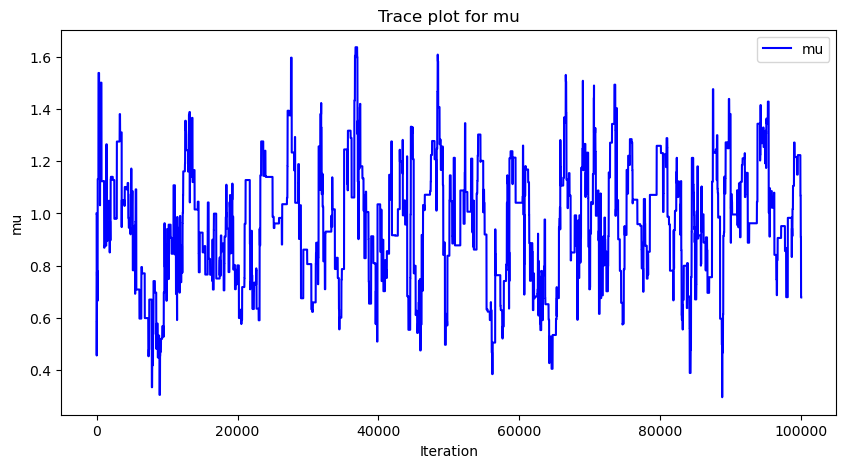

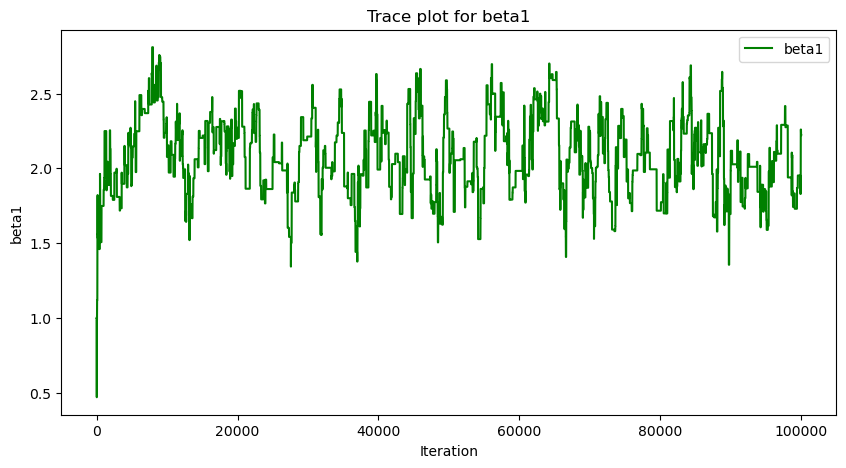

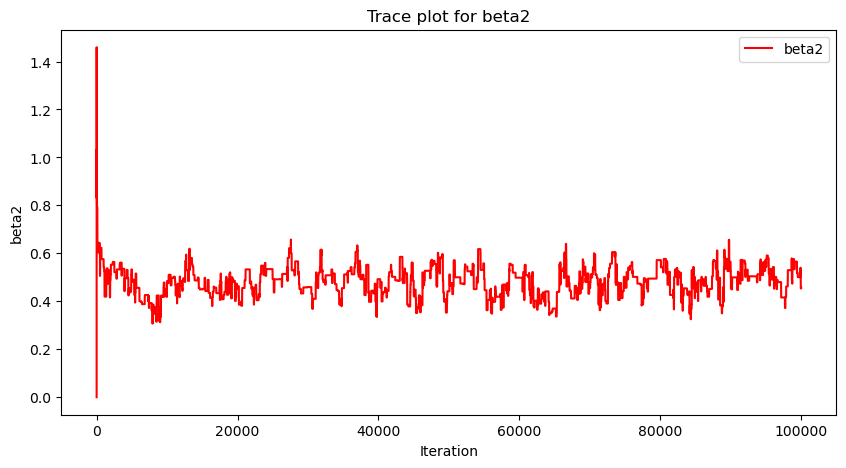

Estimated P(m=1): 1e-05


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed
np.random.seed(123)

# Generate data
x1 = np.arange(1, 10.05, 0.05)
x1 = x1 / np.std(x1)  # Standardize x1
x2 = x1 ** 2  # Quadratic term

sig = np.sqrt(0.5)
y = np.random.normal(loc=1 + 2*x1 + 0.5*x2, scale=sig, size=len(x1))

# Initialize parameters
n_mc = 100000
m = np.ones(n_mc, dtype=int)  # Model indicator (1 or 2)
h = np.array([[0.5, 0.5], [0.5, 0.5]])  # Transition probabilities between models

beta01 = np.zeros((n_mc, 2))  # Stores mu and beta1
beta2 = np.zeros(n_mc)  # Stores beta2

# Prior parameters
sig_u = np.sqrt(1)
sig_beta = np.sqrt(10)
pi_M = 0.5  # Prior probability P(m=1)
tau = np.sqrt(0.05)  # Variance of proposal density

# Initial values
m[0] = 1
beta01[0] = [1, 1]

# Full model sampling function
def samp012(b01, b2):
    curr = np.array([b01[0], b01[1], b2])
    epi = np.random.normal(0, tau, size=3)
    prop = curr + epi

    like_ratio = -np.sum(np.log(norm.pdf(y, loc=curr[0] + curr[1]*x1 + curr[2]*x2, scale=sig))) + \
                 np.sum(np.log(norm.pdf(y, loc=prop[0] + prop[1]*x1 + prop[2]*x2, scale=sig)))

    prior_ratio = -np.sum(np.log(norm.pdf(curr, loc=0, scale=sig_beta))) + \
                  np.sum(np.log(norm.pdf(prop, loc=0, scale=sig_beta)))

    acc = np.exp(like_ratio + prior_ratio)
    ind = np.random.uniform(0, 1) < acc
    return prop if ind else curr

# Reduced model sampling function
def samp01(b01):
    curr = np.array([b01[0], b01[1]])
    epi = np.random.normal(0, tau, size=2)
    prop = curr + epi

    like_ratio = -np.sum(np.log(norm.pdf(y, loc=curr[0] + curr[1]*x1, scale=sig))) + \
                 np.sum(np.log(norm.pdf(y, loc=prop[0] + prop[1]*x1, scale=sig)))

    prior_ratio = -np.sum(np.log(norm.pdf(curr, loc=0, scale=sig_beta))) + \
                  np.sum(np.log(norm.pdf(prop, loc=0, scale=sig_beta)))

    acc = np.exp(like_ratio + prior_ratio)
    ind = np.random.uniform(0, 1) < acc
    return prop if ind else curr

# RJMCMC Algorithm
for sim in range(n_mc - 1):
    if m[sim] == 1:
        chg_ind = np.random.uniform(0, 1) < h[0, 1]
        
        if chg_ind:
            u = np.random.normal(0, sig_u)
            beta2_tmp = u

            like_ratio = -np.sum(-2 * beta2_tmp * x2 * (y - beta01[sim, 0] - beta01[sim, 1] * x1) + beta2_tmp**2 * x2**2) / (2 * sig**2)
            prior_ratio = -np.log(np.sqrt(2 * np.pi) * sig_beta) - beta2_tmp**2 / (2 * sig_beta**2)
            proposal = - (np.log(np.sqrt(2 * np.pi) * sig_u) - u**2 / (2 * sig_u**2))

            acc = np.exp(like_ratio + prior_ratio - proposal)
            ind = np.random.uniform(0, 1) < acc
            
            if ind:
                m[sim+1] = 2
                beta2[sim+1] = beta2_tmp
                beta01[sim+1] = beta01[sim]
            else:
                m[sim+1] = m[sim]
                beta2[sim+1] = 0
                beta01[sim+1] = beta01[sim]
        
        else:
            beta01[sim+1] = samp01(beta01[sim])
            beta2[sim+1] = 0
            m[sim+1] = m[sim]

    if m[sim] == 2:
        chg_ind = np.random.uniform(0, 1) < h[1, 0]
        
        if chg_ind:
            u = beta2[sim]
            beta2_tmp = beta2[sim]

            like_ratio = -np.sum(-2 * beta2_tmp * x2 * (y - beta01[sim, 0] - beta01[sim, 1] * x1) + beta2_tmp**2 * x2**2) / (2 * sig**2)
            prior_ratio = -np.log(np.sqrt(2 * np.pi) * sig_beta) - beta2_tmp**2 / (2 * sig_beta**2)
            proposal = -(np.log(np.sqrt(2 * np.pi) * sig_u) - u**2 / (2 * sig_u**2))

            acc = np.exp(-like_ratio - prior_ratio + proposal)
            ind = np.random.uniform(0, 1) < acc

            if ind:
                m[sim+1] = 1
                beta2[sim+1] = 0
                beta01[sim+1] = beta01[sim]
            else:
                m[sim+1] = m[sim]
                beta01[sim+1] = beta01[sim]
                beta2[sim+1] = beta2[sim]
        
        else:
            rest = samp012(beta01[sim], beta2[sim])
            beta01[sim+1] = rest[:2]
            beta2[sim+1] = rest[2]
            m[sim+1] = m[sim]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 0], label="mu", color='blue')
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.title("Trace plot for mu")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 1], label="beta1", color='green')
plt.xlabel("Iteration")
plt.ylabel("beta1")
plt.title("Trace plot for beta1")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta2, label="beta2", color='red')
plt.xlabel("Iteration")
plt.ylabel("beta2")
plt.title("Trace plot for beta2")
plt.legend()
plt.show()

# Model probability
print("Estimated P(m=1):", np.mean(m == 1))


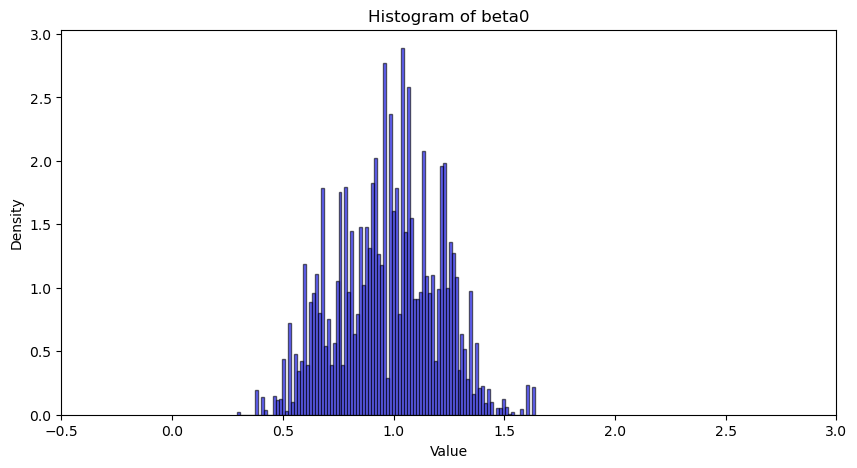

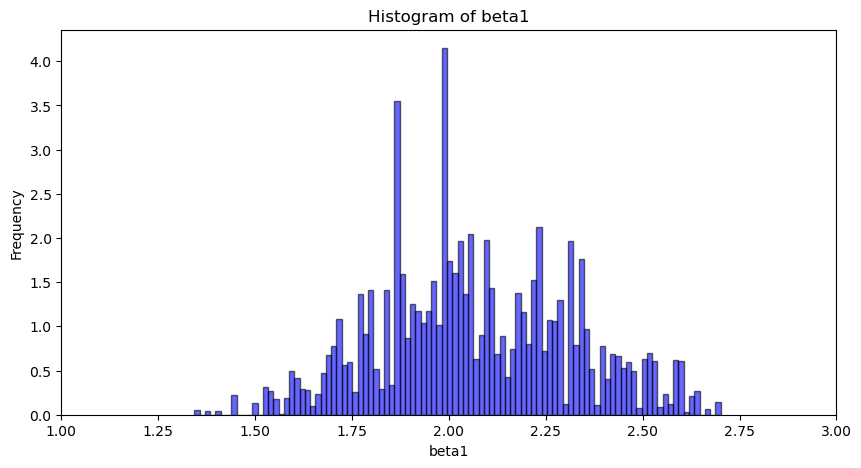

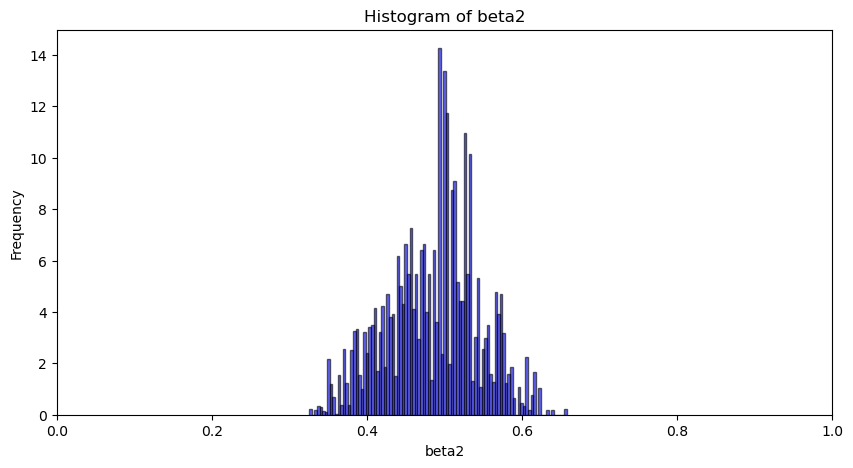

In [40]:
# Histogram for mu
plt.figure(figsize=(10, 5))
plt.hist(beta01[20000:, 0], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(-0.5, 3)  # Set x-axis limits
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of beta0')
plt.savefig("hist_mu.png")
plt.show()

# Histogram for beta1
plt.figure(figsize=(10, 5))
plt.hist(beta01[20000:, 1], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(1, 3)  # Set x-axis limits
plt.xlabel("beta1")
plt.ylabel("Frequency")
plt.title("Histogram of beta1")
plt.savefig("hist_beta1.png")
plt.show()

# Histogram for beta2
plt.figure(figsize=(10, 5))
plt.hist(beta2[20000:], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(0, 1)  # Set x-axis limits
plt.xlabel("beta2")
plt.ylabel("Frequency")
plt.title("Histogram of beta2")
plt.savefig("hist_beta2.png")
plt.show()


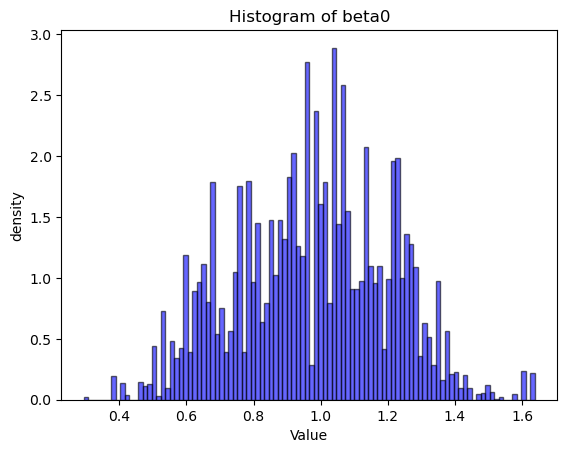

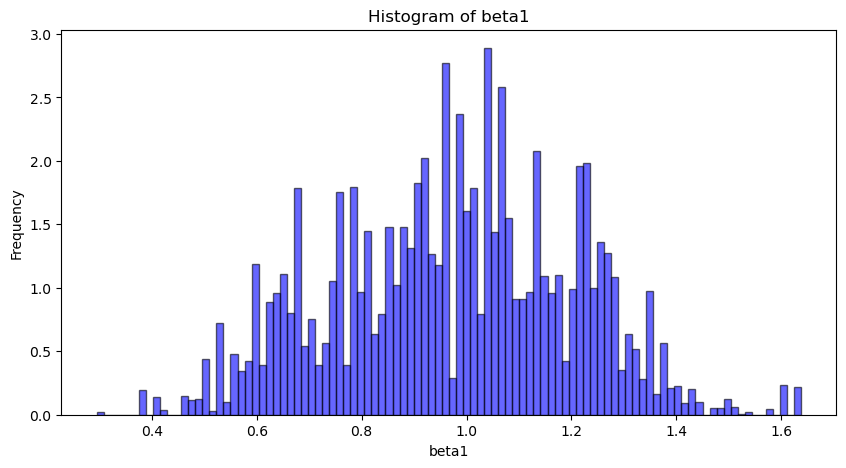

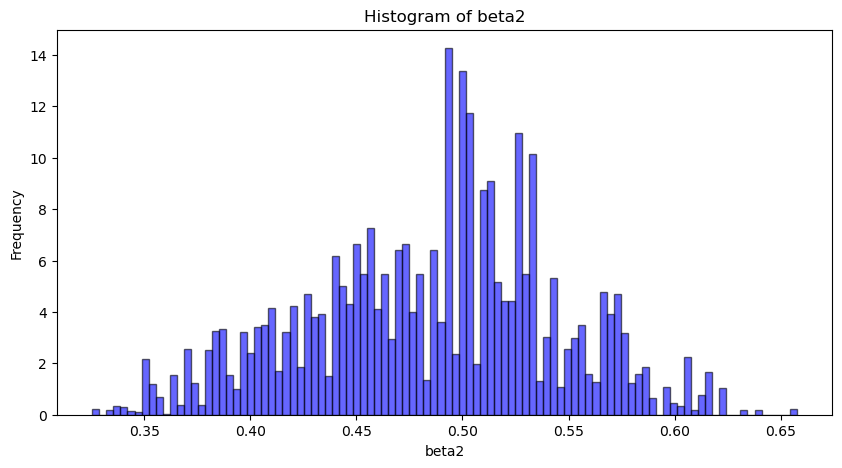

In [30]:
# Histogram for mu
# Plot the histogram
plt.hist(beta01[20000:, 0], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('density')
plt.title('Histogram of beta0')
plt.savefig("hist_mu.png")

# Histogram for beta1
plt.figure(figsize=(10, 5))
plt.hist(beta01[20000:, 0], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')

plt.xlabel("beta1")
plt.ylabel("Frequency")
plt.title("Histogram of beta1")
plt.savefig("hist_beta1.png")
plt.show()

# Histogram for beta2
plt.figure(figsize=(10, 5))
plt.hist(beta2[20000:], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlabel("beta2")
plt.ylabel("Frequency")
plt.title("Histogram of beta2")
plt.savefig("hist_beta2.png")
plt.show()


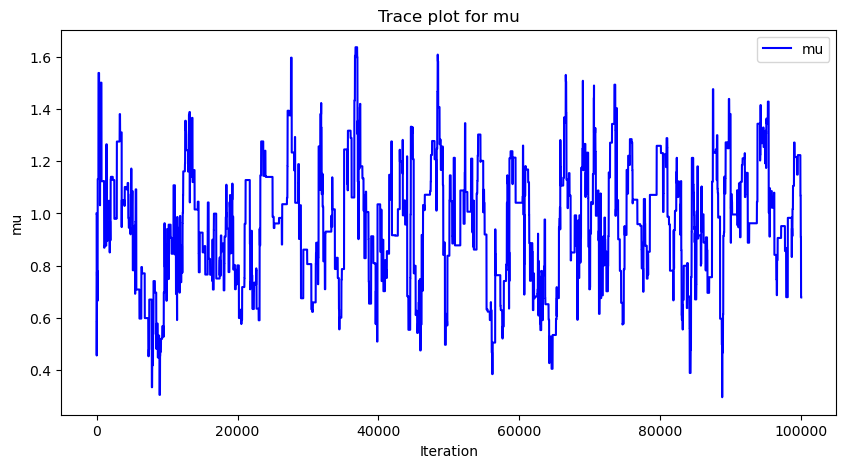

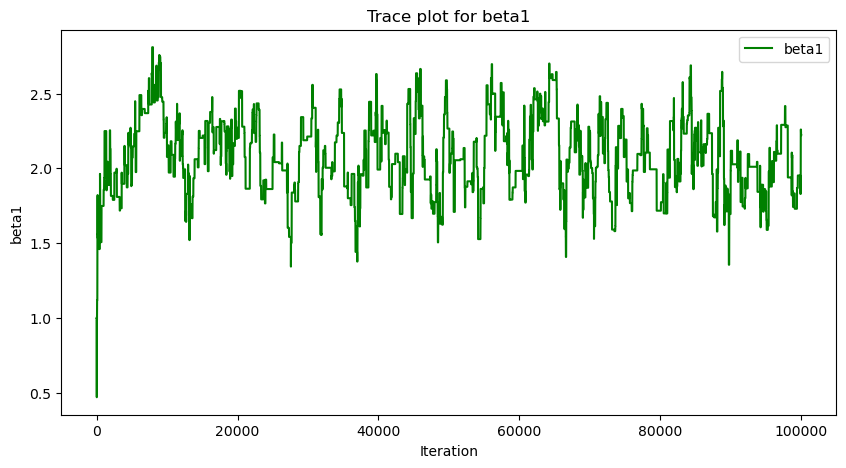

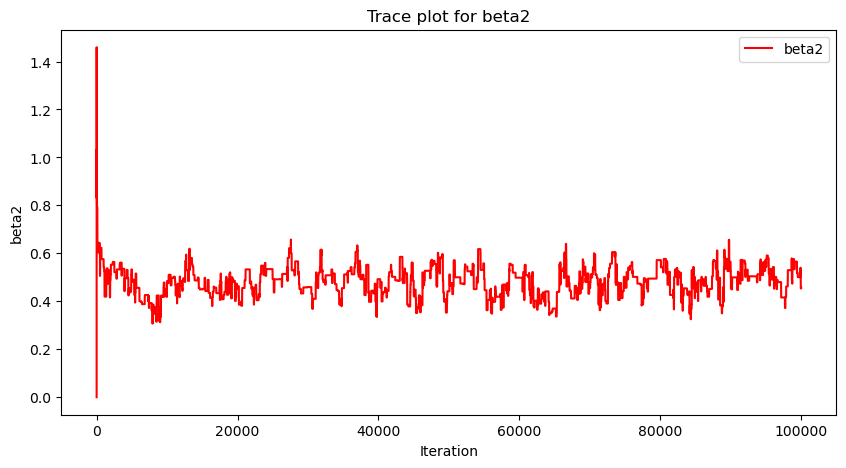

In [18]:
# Plot for mu
plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 0], label="mu", color='blue')
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.title("Trace plot for mu")
plt.legend()
plt.savefig("trace_mu.png")  # Save plot as PNG
plt.show()

# Plot for beta1
plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 1], label="beta1", color='green')
plt.xlabel("Iteration")
plt.ylabel("beta1")
plt.title("Trace plot for beta1")
plt.legend()
plt.savefig("trace_beta1.png")  # Save plot as PNG
plt.show()

# Plot for beta2
plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta2, label="beta2", color='red')
plt.xlabel("Iteration")
plt.ylabel("beta2")
plt.title("Trace plot for beta2")
plt.legend()
plt.savefig("trace_beta2.png")  # Save plot as PNG
plt.show()


In [7]:
X[0:10,:]

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337],
       [-0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783],
       [-0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272],
       [ 0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375],
       [-0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491],
       [-1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124],
       [ 0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199],
       [-0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016]])

In [9]:
import numpy as np
from scipy.stats import norm, invgamma

# Simulate data
np.random.seed(42)
n, p = 100, 5
X = np.random.randn(n, p)
beta_true = np.array([0, 1.5, 2, 0, 1])
y = X @ beta_true + np.random.randn(n)

# Priors
tau2 = 1
a, b = 1, 1
binom_prob = 0.5

# Likelihood
def log_likelihood(y, X_S, beta_S, sigma2):
    resid = y - X_S @ beta_S
    return -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * resid.T @ resid

# RJMCMC
def rjmcmc(y, X, n_iter=10000):
    k = 1  # Start with one predictor
    S = [0]  # Initial subset
    beta_S = np.array([0.0])
    sigma2 = 1.0
    trace = []

    for _ in range(n_iter):
        # Randomly choose move
        move = np.random.choice(["add", "remove", "update"], p=[0.4, 0.4, 0.2])
        
        if move == "add" and k < p:
            excluded = [j for j in range(p) if j not in S]
            j = np.random.choice(excluded)
            beta_j = np.random.randn() * np.sqrt(tau2)
            S_new = S + [j]
            beta_S_new = np.append(beta_S, beta_j)
            X_S = X[:, S]
            X_S_new = X[:, S_new]
            
            # Acceptance probability
            ll_ratio = np.exp(log_likelihood(y, X_S_new, beta_S_new, sigma2) - 
                            log_likelihood(y, X_S, beta_S, sigma2))
            prior_beta = norm.pdf(beta_j, 0, np.sqrt(tau2))
            prior_k_ratio = (p - k) / (k + 1)
            proposal_ratio = (p - k) / (k + 1)
            alpha = min(1, ll_ratio * prior_beta * prior_k_ratio * proposal_ratio)
            
            if np.random.rand() < alpha:
                S, beta_S, k = S_new, beta_S_new, k + 1
        
        elif move == "remove" and k > 0:
            j = np.random.choice(S)
            S_new = [i for i in S if i != j]
            beta_S_new = beta_S[[i for i in range(k) if S[i] != j]]
            X_S = X[:, S]
            X_S_new = X[:, S_new]
            
            # Acceptance probability (reverse of add)
            ll_ratio = np.exp(log_likelihood(y, X_S_new, beta_S_new, sigma2) - 
                            log_likelihood(y, X_S, beta_S, sigma2))
            prior_beta = norm.pdf(beta_S[S.index(j)], 0, np.sqrt(tau2))
            prior_k_ratio = k / (p - k + 1)
            proposal_ratio = k / (p - k + 1)
            alpha = min(1, ll_ratio * (1 / prior_beta) * prior_k_ratio * proposal_ratio)
            
            if np.random.rand() < alpha:
                S, beta_S, k = S_new, beta_S_new, k - 1
        
        else:  # Update beta_S and sigma2
            X_S = X[:, S]
            # Simple Metropolis step for beta_S
            beta_prop = beta_S + np.random.randn(k) * 0.1
            ll_current = log_likelihood(y, X_S, beta_S, sigma2)
            ll_prop = log_likelihood(y, X_S, beta_prop, sigma2)
            prior_ratio = np.prod(norm.pdf(beta_prop, 0, np.sqrt(tau2)) / 
                                norm.pdf(beta_S, 0, np.sqrt(tau2)))
            if np.random.rand() < min(1, np.exp(ll_prop - ll_current) * prior_ratio):
                beta_S = beta_prop
            
            # Gibbs for sigma2
            resid = y - X_S @ beta_S
            sigma2 = invgamma.rvs(a + n/2, scale=b + 0.5 * resid.T @ resid)
        
        trace.append((k, S.copy(), beta_S.copy(), sigma2))
    
    return trace

# Run simulation
trace = rjmcmc(y, X)

# Analyze results
k_trace = [t[0] for t in trace]
S_trace = [t[1] for t in trace]
print("Mean k:", np.mean(k_trace[1000:]))  # Burn-in of 1000
print("Most frequent S:", max(set(tuple(s) for s in S_trace[1000:]), key=S_trace[1000:].count))

Mean k: 3.076888888888889
Most frequent S: (4, 1, 2, 0)


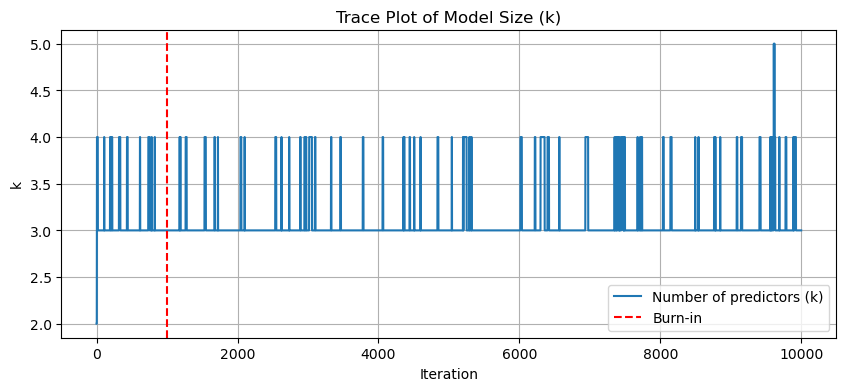

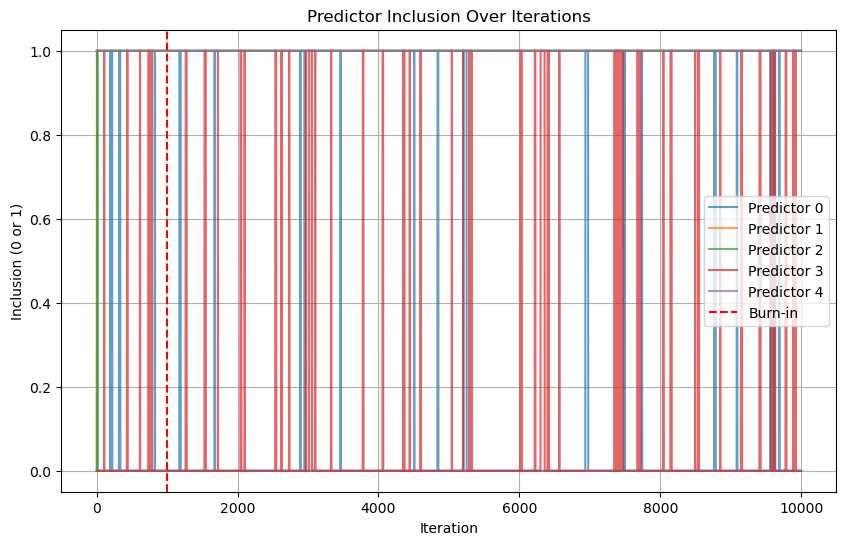

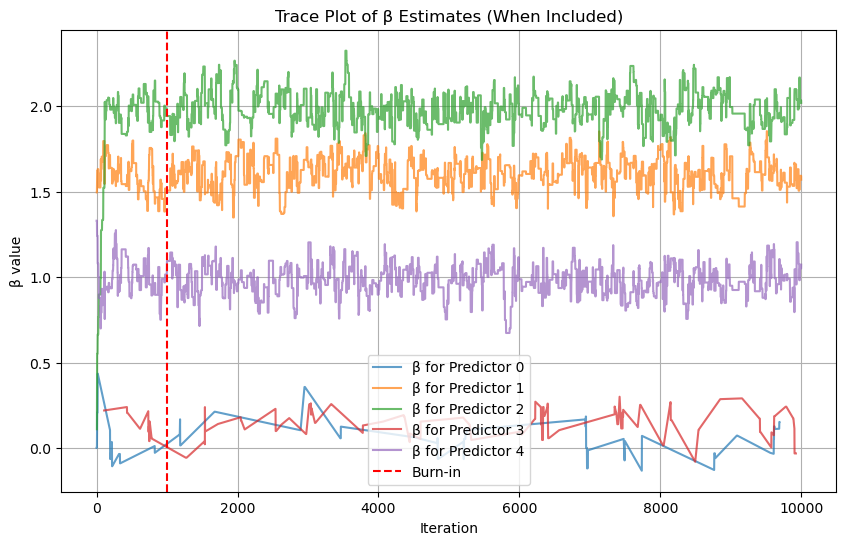

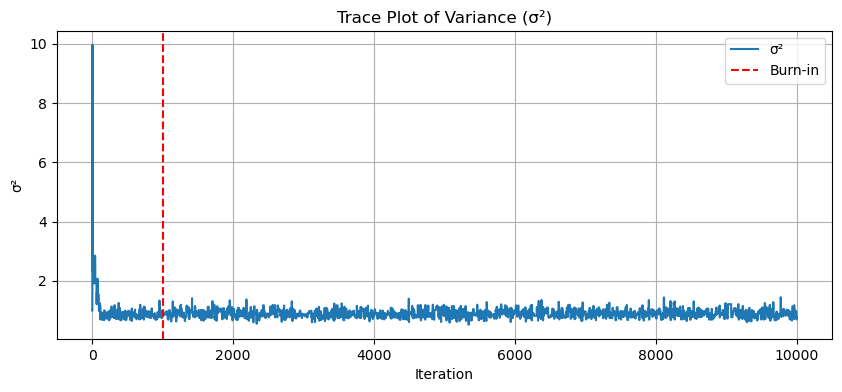

Posterior mean k: 3.076888888888889
Inclusion frequency per predictor: [0.02277778 1.         1.         0.05411111 1.        ]
Most frequent model: (4, 1, 2, 0)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assume trace is from the previous simulation
# Extract components
k_trace = [t[0] for t in trace]
S_trace = [t[1] for t in trace]
beta_trace = [t[2] for t in trace]
sigma2_trace = [t[3] for t in trace]
n_iter = len(trace)
p = 5  # Number of predictors from simulation

# Burn-in period (e.g., first 1000 iterations)
burn_in = 1000

# 1. Plot trace of k
plt.figure(figsize=(10, 4))
plt.plot(range(n_iter), k_trace, label='Number of predictors (k)')
plt.axvline(burn_in, color='red', linestyle='--', label='Burn-in')
plt.xlabel('Iteration')
plt.ylabel('k')
plt.title('Trace Plot of Model Size (k)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Predictor inclusion plot
inclusion = np.zeros((n_iter, p))  # Binary matrix: 1 if predictor is in S
for i, S in enumerate(S_trace):
    inclusion[i, S] = 1

plt.figure(figsize=(10, 6))
for j in range(p):
    plt.plot(range(n_iter), inclusion[:, j], label=f'Predictor {j}', alpha=0.7)
plt.axvline(burn_in, color='red', linestyle='--', label='Burn-in')
plt.xlabel('Iteration')
plt.ylabel('Inclusion (0 or 1)')
plt.title('Predictor Inclusion Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# 3. Simplified beta trace (for each predictor when included)
beta_by_predictor = {j: [] for j in range(p)}  # Store beta values when predictor is included
for i, (S, beta) in enumerate(zip(S_trace, beta_trace)):
    for j, b in zip(S, beta):
        beta_by_predictor[j].append((i, b))

plt.figure(figsize=(10, 6))
for j in range(p):
    if beta_by_predictor[j]:  # Only plot if predictor was included
        iters, betas = zip(*beta_by_predictor[j])
        plt.plot(iters, betas, label=f'β for Predictor {j}', alpha=0.7)
plt.axvline(burn_in, color='red', linestyle='--', label='Burn-in')
plt.xlabel('Iteration')
plt.ylabel('β value')
plt.title('Trace Plot of β Estimates (When Included)')
plt.legend()
plt.grid(True)
plt.show()

# 4. Trace of sigma^2
plt.figure(figsize=(10, 4))
plt.plot(range(n_iter), sigma2_trace, label='σ²')
plt.axvline(burn_in, color='red', linestyle='--', label='Burn-in')
plt.xlabel('Iteration')
plt.ylabel('σ²')
plt.title('Trace Plot of Variance (σ²)')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics (post burn-in)
k_post = k_trace[burn_in:]
S_post = S_trace[burn_in:]
inclusion_freq = np.mean(inclusion[burn_in:], axis=0)
print("Posterior mean k:", np.mean(k_post))
print("Inclusion frequency per predictor:", inclusion_freq)
print("Most frequent model:", max(set(tuple(s) for s in S_post), key=S_post.count))